# Notebook Imports

In [1]:
from os import walk
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

%matplotlib inline

# Constants

In [120]:
EXAMPLE_FILE='SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH='SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH='SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH='SpamData/01_Processing/spam_assassin_corpus/easy_ham_1/'
EASY_NONSPAM_2_PATH='SpamData/01_Processing/spam_assassin_corpus/easy_ham_2/'

SPAM_CAT=1
HAM_CAT=0
VOCAB_SIZE=2500

DATA_JSON_FILE='SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE='SpamData/01_Processing/word-by-id.csv'
WHALE_FILE='SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE='SpamData/01_Processing/wordcloud_resources/skull-icon.png'

TRAINING_DATA_FILE='SpamData/02_Training/train-data.txt'
TEST_DATA_FILE='SpamData/02_Training/test-data.txt'

THUMBS_UP_FILE='SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE='SpamData/01_Processing/wordcloud_resources/thumbs-down.png'

# Reading Files

In [3]:
stream=open(EXAMPLE_FILE,encoding='latin-1')
message=stream.read()

stream.close()

print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [4]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [5]:
stream=open(EXAMPLE_FILE,encoding='latin-1')
is_body=False
lines=[]

for line in stream:
    if(is_body):
        lines.append(line)
    elif line=="\n":
        is_body=True

stream.close()

email_body='\n'.join(lines)
print(email_body)




Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

In [6]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number**2

In [7]:
for i in generate_squares(5):
    
    print(i)

0
1
4
9
16


# Email Body Extraction

In [8]:
def email_body_generator(path):
    for root,dirnames,filenames in walk(path):
        for file_name in filenames:
            filepath=join(root,file_name)
            
            stream=open(filepath,encoding='latin-1')
            is_body=False
            lines=[]

            for line in stream:
                if(is_body):
                    lines.append(line)
                elif line=="\n":
                    is_body=True

            stream.close()

            email_body='\n'.join(lines)
            yield file_name,email_body

In [9]:
# How the previous cell works:
#   imagine path to be a huge set of certain directories. The walk function generates the directory 
#   tree of each and every element of the path provided. After this getting the filepath and reading 
#   the files in this path is very easy. Ultimately we are returning the email body separated by a 
#   '\n' from the header and also returning the filepath we opened to get the email body

In [10]:
def df_from_directory(path,classification):
    rows=[]
    row_names=[]
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE':email_body,'CATEGORY':classification})
        row_names.append(file_name)
        
    return pd.DataFrame(data=rows,index=row_names)

In [11]:
spam_emails=df_from_directory(SPAM_1_PATH,SPAM_CAT)
spam_emails=spam_emails.append(df_from_directory(SPAM_2_PATH,SPAM_CAT))

spam_emails.head()

,CATEGORY,MESSAGE
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00004.eac8de8d759b7e74154f142194282724,1,##############################################...
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n\n1) Slim Dow...


In [12]:
spam_emails.shape

(1898, 2)

In [13]:
ham_emails=df_from_directory(EASY_NONSPAM_1_PATH,HAM_CAT)
ham_emails=ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH,HAM_CAT))

ham_emails.head()

,CATEGORY,MESSAGE
00001.7c53336b37003a9286aba55d2945844c,0,"Date: Wed, 21 Aug 2002 10:54:46 -05..."
00002.9c4069e25e1ef370c078db7ee85ff9ac,0,"Martin A posted:\n\nTassos Papadopoulos, the G..."
00003.860e3c3cee1b42ead714c5c874fe25f7,0,Man Threatens Explosion In Moscow \n\n\n\nThur...
00004.864220c5b6930b209cc287c361c99af1,0,Klez: The Virus That Won't Die\n\n \n\nAlready...
00005.bf27cdeaf0b8c4647ecd61b1d09da613,0,"> in adding cream to spaghetti carbonara, whi..."


In [14]:
ham_emails.shape

(3901, 2)

In [15]:
data=pd.concat([spam_emails,ham_emails])
data.shape

(5799, 2)

# Data cleaning

In [16]:
data.MESSAGE.isnull().values.any()

False

In [17]:
(data.MESSAGE.str.len()==0).any()

True

In [18]:
(data.MESSAGE.str.len()==0).sum()

3

In [19]:
data[data.MESSAGE.str.len()==0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [20]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

In [21]:
(data.drop(['cmds']).MESSAGE.str.len()==0).sum()

0

In [22]:
data=data.drop(['cmds'])

In [23]:
(data.MESSAGE.str.len()==0).sum()

0

In [24]:
data.shape

(5796, 2)

In [25]:
document_ids=range(0,len(data.index))
data['DOC_ID']=document_ids

In [26]:
data.head()

,CATEGORY,MESSAGE,DOC_ID
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",0
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,2
00004.eac8de8d759b7e74154f142194282724,1,##############################################...,3
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n\n1) Slim Dow...,4


In [27]:
data['FILE_NAME']=data.index

In [28]:
data=data.set_index('DOC_ID')

# Save to file using pandas

In [29]:
data.to_json(DATA_JSON_FILE)

# Number of spam messages visualised

In [30]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [31]:
amount_of_spam=data.CATEGORY.value_counts()[1]
amount_of_ham=data.CATEGORY.value_counts()[0]

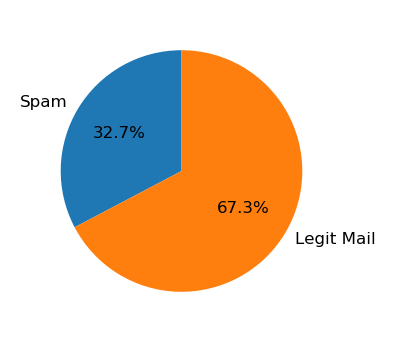

In [32]:
category_names=['Spam','Legit Mail']
sizes=[amount_of_spam,amount_of_ham]


plt.figure(figsize=(2,2),dpi=200)
plt.pie(sizes,labels=category_names,textprops={'fontsize':6},startangle=90,autopct='%1.1f%%')

plt.show()

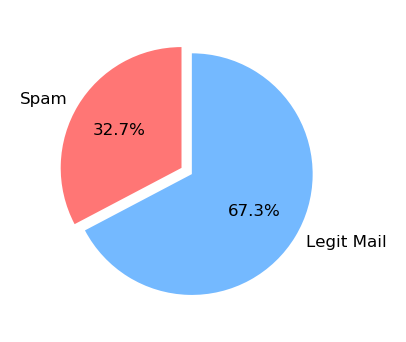

In [33]:
category_names=['Spam','Legit Mail']
sizes=[amount_of_spam,amount_of_ham]

custom_colors=['#ff7675','#74b9ff']

plt.figure(figsize=(2,2),dpi=200)
plt.pie(sizes,labels=category_names,textprops={'fontsize':6},
        startangle=90,autopct='%1.1f%%',colors=custom_colors,explode=[0.05,0.05])

plt.show()

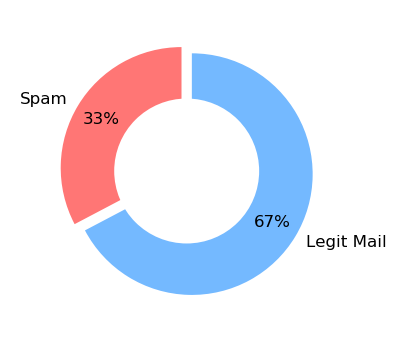

In [34]:
category_names=['Spam','Legit Mail']
sizes=[amount_of_spam,amount_of_ham]

custom_colors=['#ff7675','#74b9ff']
offset=[0.05,0.05]

plt.figure(figsize=(2,2),dpi=200)
plt.pie(sizes,labels=category_names,textprops={'fontsize':6},
        startangle=90,autopct='%1.0f%%',colors=custom_colors,pctdistance=0.78,explode=offset)

centre_circle=plt.Circle((0,0),radius=0.6,fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

# NLP

## Text pre-processing

In [35]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Sushant
[nltk_data]     Lenka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [36]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Sushant
[nltk_data]     Lenka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [37]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to C:\Users\Sushant
[nltk_data]     Lenka\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to C:\Users\Sushant
[nltk_data]     Lenka\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

## Tokenizing

In [38]:
msg='This is a Sample Message which Has to be TOKENIZED.'

In [39]:
word_tokenize(msg.lower())

['this',
 'is',
 'a',
 'sample',
 'message',
 'which',
 'has',
 'to',
 'be',
 'tokenized',
 '.']

## Removing Stop Words

In [40]:
stop_words=set(stopwords.words('english'))

In [41]:
if 'this' in stop_words: print('Found')

Found


In [42]:
msg='All work and no play makes Jack a dull boy. To be or not to be.'
words=word_tokenize(msg.lower())

In [43]:
filtered_words=[]
for word in words:
    if word not in stop_words:
        filtered_words.append(word)
        
print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']


## Word stems and stemming

In [44]:
msg='All work and no play makes Jack a dull boy. To be or not to be. \
Nobody expects the spanish inquisition!'
words=word_tokenize(msg.lower())

# stemmer=PorterStemmer()
stemmer=SnowballStemmer('english')

filtered_words=[]
for word in words:
    if word not in stop_words:
        stemmed_word=stemmer.stem(word)
        filtered_words.append(stemmed_word)
        
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit', '!']


## Removing Punctuations

In [45]:
msg='All work and no play makes Jack a dull boy. To be or not to be. \
Nobody expects the spanish inquisition!'
words=word_tokenize(msg.lower())

# stemmer=PorterStemmer()
stemmer=SnowballStemmer('english')

filtered_words=[]
for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word=stemmer.stem(word)
        filtered_words.append(stemmed_word)
        
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


In [46]:
'p'.isalpha()

True

## Removing HTML tags

In [47]:
soup=BeautifulSoup(data.at[0,'MESSAGE'],'html.parser')
print(soup.prettify())

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">
<html>
 <head>
  <meta charset="utf-8" content='3D"text/html;' http-equiv="3DContent-T=" ype=""/>
  <meta 5.00.2314.1000"="" content='3D"MSHTML' name="3DGENERATOR"/>
 </head>
 <body>
  <!-- Inserted by Calypso -->
  <table black;="" border="3D0" cellpadding="3D0" cellspacing="3D2" display:="" id="3D_CalyPrintHeader_" none"="" r="ules=3Dnone" style='3D"COLOR:' width='3D"100%"'>
   <tbody>
    <tr>
     <td colspan="3D3">
      <hr color="3Dblack" noshade="" size="3D1"/>
     </td>
    </tr>
   </tbody>
  </table>
 </body>
</html>
<tr>
 <td colspan="3D3">
  <hr color="3Dblack" noshade="" size="3D1"/>
 </td>
</tr>
<!-- End Calypso -->
<!-- Inserted by Calypso=

 -->
<font color="3D#000000" face="3DVERDANA,ARIAL,HELVETICA" size="3D-2">
 <br/>
</font>
&lt;=

/TR&gt;
<!-- End Calypso -->
<font bold"="" color="3D#ff0000" face='3D"Copperplate' gothic="" ptsize='3D"10"' size="3D5">
 <center>
  Save up to 70% on Life Insurance.
 </ce

In [48]:
soup.get_text()

"\n\n\n\n\n\n\n\n\n\n\n\n\n\n<=\n\n/TR>\nSave up to 70% on Life Insurance.\nWhy Spend More Than You Have To?\n\n\nLife Quote Savings\n\n\n\n\n\n\n\n\n\n\n\nEnsurin=\n\ng your \n\n      family's financial security is very important. Life Quote Savings ma=\n\nkes \n\n      buying life insurance simple and affordable. We Provide FREE Access =\n\nto The \n\n      Very Best Companies and The Lowest Rates.\n\n\n\n\n\nLife Quote Savings is FAST, EAS=\n\nY and \n\n            SAVES you money! Let us help you get started with the best val=\n\nues in \n\n            the country on new coverage. You can SAVE hundreds or even tho=\n\nusands \n\n            of dollars by requesting a FREE quote from Lifequote Savings. =\n\nOur \n\n            service will take you less than 5 minutes to complete. Shop an=\n\nd \n\n            compare. SAVE up to 70% on all types of Life insurance! \n\n\n\n\nClick Here For Your=\n\n \n\n            Free Quote!\n\nProtecting your family is the best investment you'll 

## Functions for email processing

In [49]:
def clean_message(message,stemmer=PorterStemmer(),
                  stop_words=set(stopwords.words('english'))):
    
    words=word_tokenize(message.lower())
    
    filtered_words=[]
    
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    
    return filtered_words
    

In [50]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [51]:
def clean_message_no_html(message,stemmer=PorterStemmer(),
                  stop_words=set(stopwords.words('english'))):
    
    soup=BeautifulSoup(message,'html.parser')
    message_without_html=soup.get_text()
    
    words=word_tokenize(message_without_html.lower())
    
    filtered_words=[]
    
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    
    return filtered_words
    

In [52]:
clean_message_no_html(data.at[0,'MESSAGE'])

['save',
 'life',
 'insur',
 'spend',
 'life',
 'quot',
 'save',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'rate',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',
 'us',
 'help',
 'get',
 'start',
 'best',
 'ue',
 'countri',
 'new',
 'coverag',
 'save',
 'hundr',
 'even',
 'usand',
 'dollar',
 'request',
 'free',
 'quot',
 'lifequot',
 'save',
 'servic',
 'take',
 'less',
 'minut',
 'complet',
 'shop',
 'compar',
 'save',
 'type',
 'life',
 'insur',
 'click',
 'free',
 'quot',
 'protect',
 'famili',
 'best',
 'invest',
 'r',
 'make',
 'receipt',
 'email',
 'error',
 'wish',
 'remov',
 'list',
 'pleas',
 'click',
 'type',
 'remov',
 'resid',
 'state',
 'prohibit',
 'solicit',
 'ce',
 'pleas',
 'disregard',
 'email']

## Cleaning all email bodies

In [53]:
first_emails=data.MESSAGE.iloc[0:5]

nested_list=first_emails.apply(clean_message_no_html)

In [54]:
flat_list=[]

for sub_item in nested_list:
    for item in sub_item:
        flat_list.append(item)
        
print(flat_list)

['save', 'life', 'insur', 'spend', 'life', 'quot', 'save', 'g', 'famili', 'financi', 'secur', 'import', 'life', 'quot', 'save', 'ke', 'buy', 'life', 'insur', 'simpl', 'afford', 'provid', 'free', 'access', 'best', 'compani', 'lowest', 'rate', 'life', 'quot', 'save', 'fast', 'save', 'money', 'let', 'us', 'help', 'get', 'start', 'best', 'ue', 'countri', 'new', 'coverag', 'save', 'hundr', 'even', 'usand', 'dollar', 'request', 'free', 'quot', 'lifequot', 'save', 'servic', 'take', 'less', 'minut', 'complet', 'shop', 'compar', 'save', 'type', 'life', 'insur', 'click', 'free', 'quot', 'protect', 'famili', 'best', 'invest', 'r', 'make', 'receipt', 'email', 'error', 'wish', 'remov', 'list', 'pleas', 'click', 'type', 'remov', 'resid', 'state', 'prohibit', 'solicit', 'ce', 'pleas', 'disregard', 'email', 'fight', 'risk', 'cancer', 'http', 'slim', 'guarante', 'lose', 'lb', 'day', 'http', 'get', 'child', 'support', 'deserv', 'free', 'legal', 'advic', 'http', 'join', 'web', 'fastest', 'grow', 'singl',

In [55]:
len(flat_list)

442

In [56]:
%%time

nested_list=data.MESSAGE.apply(clean_message_no_html)

C:\Users\Sushant Lenka\.conda\envs\machineLearning\lib\site-packages\bs4\__init__.py:335: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Wall time: 32.1 s


In [57]:
nested_list.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

In [58]:
nested_list.at[5791]

['http',
 'bizarr',
 'collect',
 'stuf',
 'anim',
 'could',
 'fetch',
 'sold',
 'cornwal',
 'museum',
 'museum',
 'curios',
 'home',
 'menageri',
 'victorian',
 'stuf',
 'anim',
 'museum',
 'next',
 'jamaica',
 'inn',
 'bodmin',
 'moor',
 'get',
 'visitor',
 'year',
 'inn',
 'owner',
 'kevin',
 'moor',
 'decid',
 'sell',
 'stuf',
 'frog',
 'sale',
 'mr',
 'moor',
 'said',
 'fashion',
 'taxidermi',
 'mantlepiec',
 'victorian',
 'time',
 'realli',
 'favour',
 'nevertheless',
 'figur',
 'collect',
 'discuss',
 'museum',
 'open',
 'taxidermist',
 'walter',
 'potter',
 'tableaux',
 'includ',
 'kitten',
 'tea',
 'parti',
 'guinea',
 'pig',
 'swing',
 'frog',
 'yahoo',
 'group',
 'sponsor',
 'share',
 'magic',
 'harri',
 'potter',
 'yahoo',
 'messeng',
 'http',
 'unsubscrib',
 'group',
 'send',
 'email',
 'use',
 'yahoo',
 'group',
 'subject',
 'http']

In [59]:
data.at[5791,'MESSAGE']

'http://news.bbc.co.uk/1/hi/england/2515127.stm\n\n\n\nA bizarre collection of stuffed animals could fetch up to £2m when it is\n\nsold by a Cornwall museum.\n\nThe Museum of Curiosities is home to a menagerie of 10,000 Victorian stuffed\n\nanimals.\n\nThe museum, next to the Jamaica Inn on Bodmin Moor, gets about 30,000\n\nvisitors a year.\n\nBut now the inn\'s owner Kevin Moore has decided to sell.\n\n\n\nStuffed frogs are for sale\n\n\n\nMr Moore said: "It was very fashionable to have taxidermy on your\n\nmantlepiece in Victorian times, but it is not really in favour now."\n\nNevertheless, figures of up to £2m for the collection have been discussed.\n\nThe museum was opened in 1861 by taxidermist Walter Potter.\n\nTableaux include a kittens tea party, cricket-playing guinea pigs and\n\nswinging frogs.\n\n\n\n\n\n------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\nShare the magic of Harry Potter with Yahoo! Messenger\n\nhttp://us.click.yahoo.com/4Q_cgB/JmBFAA/

In [60]:
doc_ids_spam=data[data.CATEGORY==1].index
doc_ids_ham=data[data.CATEGORY==0].index

In [61]:
nested_list_ham=nested_list.loc[doc_ids_ham]
nested_list_ham.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

In [62]:
nested_list_spam=nested_list.loc[doc_ids_spam]
nested_list_spam.tail()

DOC_ID
1891    [want, boss, train, home, studi, thousand, peo...
1892    [messag, mime, format, prefer, doctor, order, ...
1893    [dear, subscrib, could, show, way, get, visito...
1894    [custom, appreci, sale, express, appreci, loya...
1895    [attn, strictli, confidenti, pleas, introduc, ...
Name: MESSAGE, dtype: object

In [63]:
number_of_words=0
for word in nested_list:
    number_of_words+=len(word)
    
print(number_of_words)

761974


In [64]:
number_of_words=0
for word in nested_list_ham:
    number_of_words+=len(word)
    
print(number_of_words)

441403


In [65]:
number_of_words=0
for word in nested_list_spam:
    number_of_words+=len(word)
    
print(number_of_words)

320571


In [66]:
f_list_ham=[item for sublist in nested_list_ham for item in sublist]
normal_words=pd.Series(f_list_ham).value_counts()

normal_words.shape[0]

20755

In [67]:
normal_words[:10]

http      7561
use       3630
list      2878
one       2371
get       2284
mail      2255
would     2003
like      1928
messag    1847
work      1798
dtype: int64

In [68]:
f_list_spam=[item for sublist in nested_list_spam for item in sublist]
spam_words=pd.Series(f_list_spam).value_counts()

spam_words.shape[0]

13284

In [69]:
spam_words[:10]

http      3101
email     3094
free      2555
click     2058
receiv    1987
list      1974
get       1903
pleas     1842
busi      1792
order     1743
dtype: int64

## Creating a wordcloud

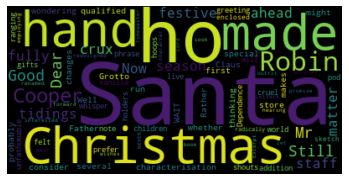

In [70]:
word_cloud=WordCloud().generate(email_body)
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [71]:
example_corpus=nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [72]:
word_list=[''.join(word) for word in example_corpus]
novel_as_string=' '.join(word_list)

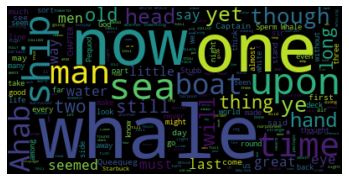

In [73]:
word_cloud=WordCloud().generate(novel_as_string)
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

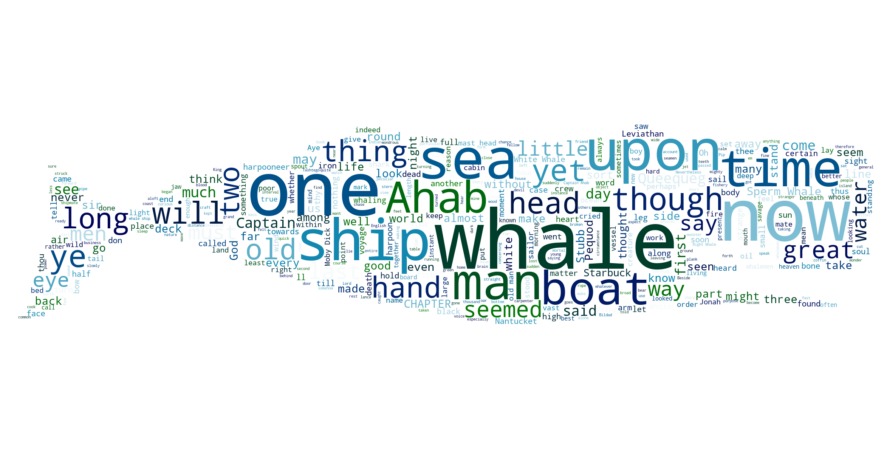

In [74]:
icon=Image.open(WHALE_FILE)
image_mask=Image.new(mode='RGB',size=icon.size,color=(255,255,255))
image_mask.paste(icon,box=icon)
rgb_array=np.array(image_mask)

word_cloud=WordCloud(mask=rgb_array,background_color='white',max_words=400,colormap='ocean')
word_cloud.generate(novel_as_string)

plt.figure(figsize=[16,8])
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [75]:
skull_corpus=nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
word_list=[''.join(word) for word in skull_corpus]
novel_as_string=' '.join(word_list)

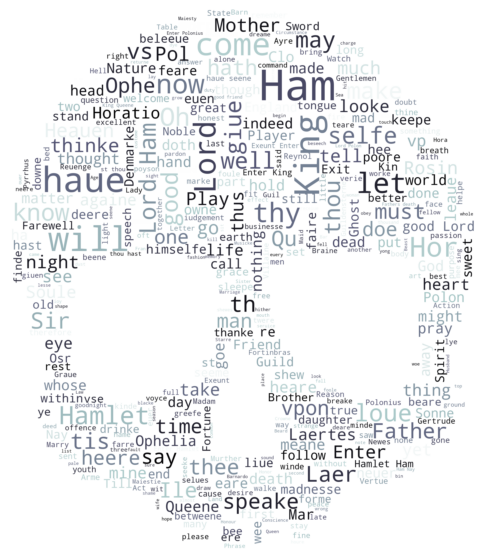

In [76]:
icon=Image.open(SKULL_FILE)
image_mask=Image.new(mode='RGB',size=icon.size,color=(255,255,255))
image_mask.paste(icon,box=icon)
rgb_array=np.array(image_mask)

word_cloud=WordCloud(mask=rgb_array,background_color='white',max_words=400,colormap='bone')
word_cloud.generate(novel_as_string)

plt.figure(figsize=[16,10])
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

## Wordcloud for spam messages

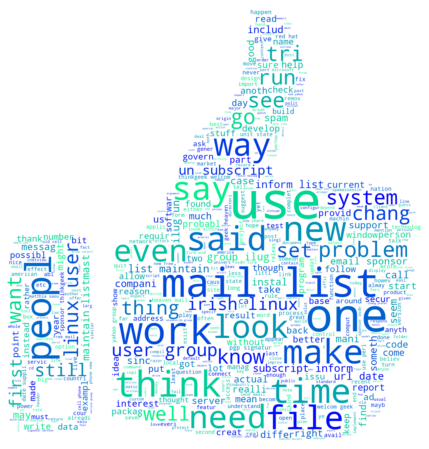

In [77]:
icon=Image.open(THUMBS_UP_FILE)
image_mask=Image.new(mode='RGB',size=icon.size,color=(255,255,255))
image_mask.paste(icon,box=icon)
rgb_array=np.array(image_mask)

ham_str=' '.join(f_list_ham)

word_cloud=WordCloud(mask=rgb_array,background_color='white',max_words=500,colormap='winter')
word_cloud.generate(ham_str)

plt.figure(figsize=[16,8])
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

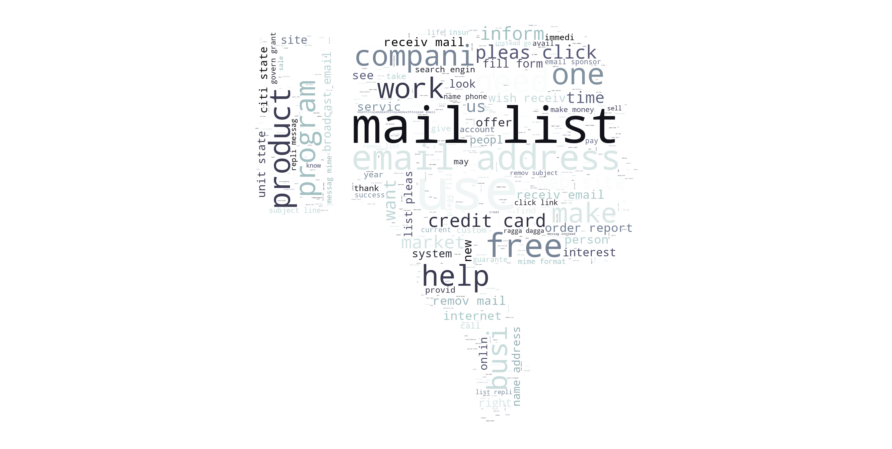

In [78]:
icon=Image.open(THUMBS_DOWN_FILE)
image_mask=Image.new(mode='RGB',size=icon.size,color=(255,255,255))
image_mask.paste(icon,box=icon)
rgb_array=np.array(image_mask)

spam_str=' '.join(f_list_spam)

word_cloud=WordCloud(mask=rgb_array,background_color='white',max_words=500,colormap='bone')
word_cloud.generate(spam_str)

plt.figure(figsize=[16,8])
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

## Generate vocab and dictionary

In [79]:
stemmed_nested_list=data.MESSAGE.apply(clean_message_no_html)

In [80]:
flat_stemmed_list=[item for sublist in stemmed_nested_list for item in sublist]


In [81]:
unique_words=pd.Series(flat_stemmed_list).value_counts()

In [82]:
unique_words.head()

http     10662
use       5017
list      4852
email     4370
get       4187
dtype: int64

In [83]:
frequent_words=unique_words[0:VOCAB_SIZE]

In [84]:
frequent_words

http          10662
use            5017
list           4852
email          4370
get            4187
mail           3985
one            3905
free           3171
time           3090
work           2880
messag         2787
make           2777
like           2765
would          2746
peopl          2671
new            2667
inform         2662
receiv         2476
pleas          2177
click          2145
busi           2135
address        2133
want           2059
us             2015
need           2003
order          1992
remov          1965
also           1878
go             1856
year           1835
              ...  
ximian           44
con              44
everywher        44
leas             44
anthoni          44
potent           44
bullet           44
navig            44
subsequ          44
pci              44
layer            44
fashion          44
asian            44
decreas          44
council          44
burner           44
contest          44
raid             44
zone             44


In [85]:
word_ids=list(range(0,VOCAB_SIZE))

In [86]:
vocab=pd.DataFrame({'VOCAB_WORD':frequent_words.index.values},index=word_ids)
vocab.index.name='WORD_ID'

In [87]:
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


In [88]:
vocab.to_csv(WORD_ID_FILE,index_label=vocab.index.name,header=vocab.VOCAB_WORD.name)

## Generating features and a sparce matrix

In [89]:
word_columns_df=pd.DataFrame.from_records(stemmed_nested_list.tolist())

In [90]:
word_columns_df.shape

(5796, 7671)

In [91]:
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


## Split data into train and test split

In [93]:

X_train, X_test, y_train, y_test = train_test_split(word_columns_df,data.CATEGORY,test_size=0.3,random_state=42)

In [95]:
X_train.shape

(4057, 7671)

In [98]:
X_train.index.name=X_test.index.name ='DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,ye,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [99]:
y_train.head()

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

### Create a Sparse Matrix for the Training Data

In [100]:
word_index=pd.Index(vocab.VOCAB_WORD)

In [102]:
word_index.get_loc('html')

674

In [109]:
def make_sparse_matrix(df,indexed_words,labels):
    nr_rows=df.shape[0]
    nr_cols=df.shape[1]
    word_set=set(indexed_words)
    dict_list=[]
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            word=df.iat[i,j]
            if(word in word_set):
                doc_id=df.index[i]
                word_id=indexed_words.get_loc(word)
                category=labels.at[doc_id]
                item={'LABEL':category,'DOC_ID':doc_id,'OCCURENCE':1,'WORD_ID':word_id}
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)

In [110]:
sparse_train_df=make_sparse_matrix(X_train,word_index,y_train)
# Takes around 10 mins aaaaahhhhhhhhhhhhhhh

In [111]:
sparse_train_df[:5]

,DOC_ID,LABEL,OCCURENCE,WORD_ID
0,4844,0,1,266
1,4844,0,1,1267
2,4844,0,1,508
3,4844,0,1,310
4,4844,0,1,255


In [113]:
sparse_train_df.shape

(430996, 4)

In [125]:
train_grouped=sparse_train_df.groupby(['DOC_ID','WORD_ID','LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1

In [126]:
train_grouped=train_grouped.reset_index()
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
258355,5795,2048,0,1
258356,5795,2055,0,1
258357,5795,2284,0,1
258358,5795,2374,0,1
258359,5795,2412,0,1


### Save training data as .txt file

In [127]:
np.savetxt(TRAINING_DATA_FILE,train_grouped,fmt='%d')

In [128]:
sparse_test_df=make_sparse_matrix(X_test,word_index,y_test)
test_grouped=sparse_test_df.groupby(['DOC_ID','WORD_ID','LABEL']).sum()
test_grouped=test_grouped.reset_index()

In [122]:
np.savetxt(TEST_DATA_FILE,test_grouped,fmt='%d')

In [123]:
test_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
117623,5793,2352,0,2
117624,5793,2377,0,1
117625,5793,2394,0,4
117626,5793,2416,0,3
117627,5793,2480,0,1


In [124]:
train_grouped.columns

Index(['index', 'DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')